In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("loans.xlsx")

In [3]:
df

,ID,LOAN_ID,USER_ID,CREATED_AT,AMOUNT_DISBURSED,AMOUNT_FEE,NUM_REPAYMENTS,DAYS_BTWN_REPAYMENTS,LOAN_TERM_DAYS,LOAN_STATUS,DISBURSED_AT,USER_LOAN_RANK,PAID_IN_FULL_AT,CREDIT_SCORE,AMOUNT_REPAID
0,0,6669019,3392612,26/06/18,3100,432,4,7,28,repaid,26/06/18,4,15/07/18,0.8988,3532
1,1,5699091,942534,2018-11-05 00:00:00,5000,695,1,28,28,repaid,2018-11-05 00:00:00,9,2018-07-06 00:00:00,0.8653,5696
2,2,5774993,3057207,15/05/18,1000,152,4,7,28,repaid,15/05/18,2,2018-12-06 00:00:00,0.8308,1162
3,3,6413412,1852716,14/06/18,5000,664,4,7,28,repaid,14/06/18,10,25/06/18,0.8690,5664
4,4,5233927,2804658,19/04/18,3100,452,1,28,28,repaid,19/04/18,2,2018-04-07 00:00:00,0.8267,3552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,5696921,1425912,2018-11-05 00:00:00,12000,2072,8,7,56,repaid,2018-11-05 00:00:00,13,31/05/18,0.8763,14270
99996,99996,6642372,2964579,24/06/18,250,38,4,7,28,repaid,24/06/18,1,26/06/18,0.5042,288
99997,99997,6224409,2019864,2018-05-06 00:00:00,4000,574,1,28,28,repaid,2018-05-06 00:00:00,5,2018-03-07 00:00:00,0.9020,4574
99998,99998,6078756,3516465,29/05/18,250,38,4,7,28,repaid,30/05/18,1,2018-02-06 00:00:00,0.5558,290


In [4]:
df.shape

(100000, 15)

In [6]:
df.columns

Index(['ID', 'LOAN_ID', 'USER_ID', 'CREATED_AT', 'AMOUNT_DISBURSED',
       'AMOUNT_FEE', 'NUM_REPAYMENTS', 'DAYS_BTWN_REPAYMENTS',
       'LOAN_TERM_DAYS', 'LOAN_STATUS', 'DISBURSED_AT', 'USER_LOAN_RANK',
       'PAID_IN_FULL_AT', 'CREDIT_SCORE', 'AMOUNT_REPAID'],
      dtype='object')

In [7]:
print("Number of NaNs: ",df['PAID_IN_FULL_AT'].isnull().sum().sum())
print("Number of defaulted loans:",list(df['LOAN_STATUS']).count('defaulted'))

Number of NaNs:  11135
Number of defaulted loans: 11135


# Default Rates Across Credit Score Categories
 

  Credit_Score_Category  total_loans  defaulted_loans  repaid_loans  \
0              Very Low          907              258           649   
1                   Low         9460             1837          7623   
2                Medium         8013             1221          6792   
3                  High         9403             1291          8112   
4             Very High        72217             6528         65689   

   default_rate  
0     28.445424  
1     19.418605  
2     15.237739  
3     13.729661  
4      9.039423  


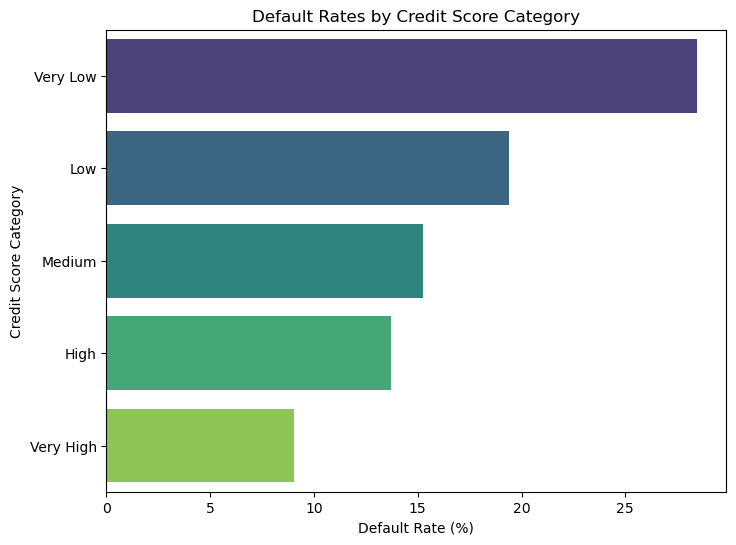

In [8]:
df['PAID_IN_FULL_AT'] = pd.to_datetime(df['PAID_IN_FULL_AT'], errors='coerce')
df['DISBURSED_AT'] = pd.to_datetime(df['DISBURSED_AT'], errors='coerce')
df['is_default'] = df['PAID_IN_FULL_AT'].isnull().astype(int)

def categorize_credit_score(score):
    if score < 0.5:
        return "Very Low"
    elif 0.5 <= score < 0.6:
        return "Low"
    elif 0.6 <= score < 0.7:
        return "Medium"
    elif 0.7 <= score < 0.8:
        return "High"
    else:
        return "Very High"

df['Credit_Score_Category'] = df['CREDIT_SCORE'].apply(categorize_credit_score)
credit_score_order = ["Very Low", "Low", "Medium", "High", "Very High"]
df['Credit_Score_Category'] = pd.Categorical(df['Credit_Score_Category'], categories=credit_score_order, ordered=True)

# Grouping data by Credit Score
credit_score_analysis = df.groupby('Credit_Score_Category').agg(
    total_loans=('LOAN_ID', 'count'),
    defaulted_loans=('is_default', 'sum'),
    repaid_loans=('is_default', lambda x: len(x) - x.sum()),
    default_rate=('is_default', 'mean')
).reset_index()
credit_score_analysis['default_rate'] = credit_score_analysis['default_rate'] * 100
print(credit_score_analysis)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(
    data=credit_score_analysis,
    y='Credit_Score_Category',
    x='default_rate',
    palette='viridis'
)
plt.title("Default Rates by Credit Score Category")
plt.xlabel("Default Rate (%)")
plt.ylabel("Credit Score Category")
plt.show()

# Default Rates by Loan Rank


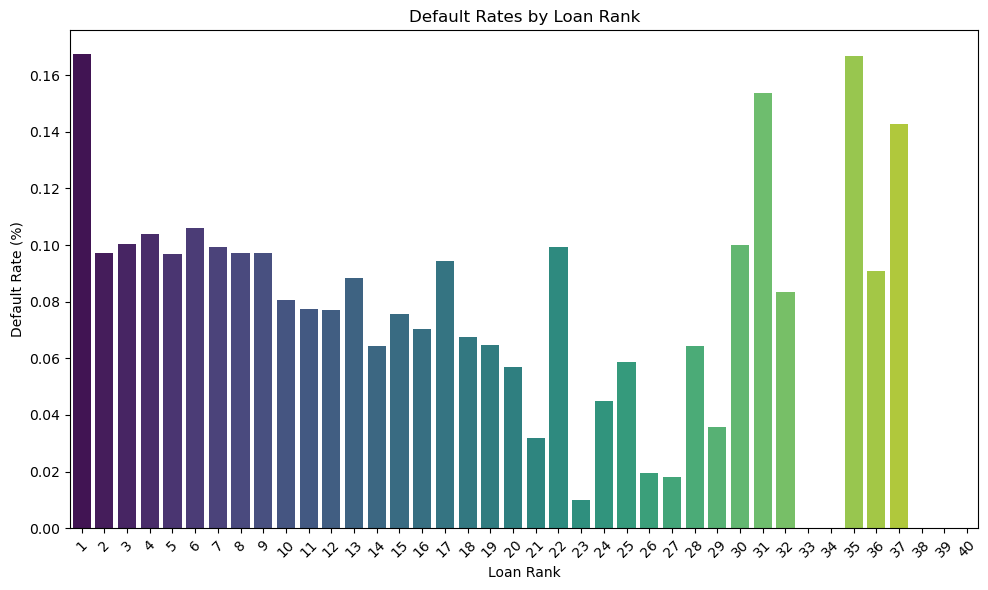

In [9]:
loan_rank_default_rates = df.groupby('USER_LOAN_RANK')['is_default'].mean().reset_index()

# Loan ranks greater than 40
loan_rank_default_rates = loan_rank_default_rates[loan_rank_default_rates['USER_LOAN_RANK'] <= 40]

# Default Rates by Loan Rank
plt.figure(figsize=(10, 6))
sns.barplot(
    x='USER_LOAN_RANK', 
    y='is_default', 
    data=loan_rank_default_rates, 
    palette='viridis'
)
plt.title("Default Rates by Loan Rank")
plt.xlabel("Loan Rank")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Loan Status Distribution by Loan Amount

<Figure size 1200x800 with 0 Axes>

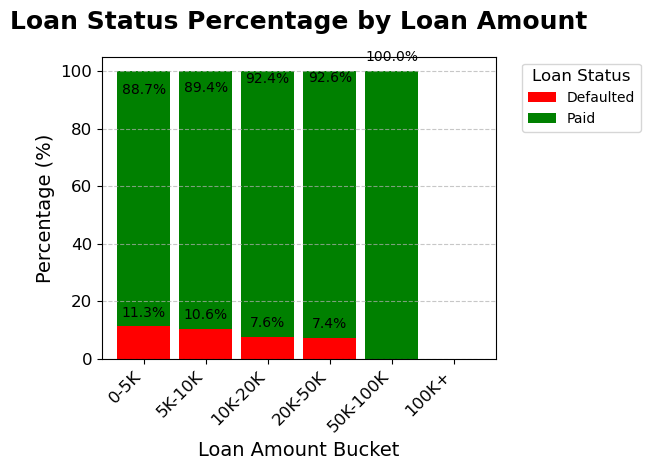

In [8]:
bins = [0, 5000, 10000, 20000, 50000, 100000, float('inf')]
labels = ['0-5K', '5K-10K', '10K-20K', '20K-50K', '50K-100K', '100K+']
df['Loan_Amount_Bucket'] = pd.cut(df['AMOUNT_DISBURSED'], bins=bins, labels=labels)
loan_status_percentage = df.groupby(['Loan_Amount_Bucket', 'LOAN_STATUS']).size().unstack(fill_value=0)
loan_status_percentage = loan_status_percentage.div(loan_status_percentage.sum(axis=1), axis=0) * 100

#Bar plot for Loan Status Percentages by Loan Amount
plt.figure(figsize=(12, 8))
colors = ['red','green']
loan_status_percentage.plot(kind='bar', stacked=True, color=colors, width=0.85)
plt.title('Loan Status Percentage by Loan Amount', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Loan Amount Bucket', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0: 
        plt.gca().annotate(f'{height:.1f}%', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           xytext=(0, 5), 
                           textcoords='offset points',
                           ha='center', va='bottom', fontsize=10, color='black')
plt.legend(title='Loan Status', labels=['Defaulted', 'Paid'], bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()


# Customer Segmentation Based on Loan Rank and Credit Score


       Segment  Avg Loan Rank  Min Loan Rank  Max Loan Rank  Avg Credit Score  \
0    High Risk       4.108283              1              8          0.851713   
1     Low Risk      12.680140              9             74          0.862200   
2  Medium Risk       1.017966              1              9          0.601435   

   Min Credit Score  Max Credit Score  Default Rate  
0            0.6916            0.9681      0.098350  
1            0.6016            0.9631      0.080113  
2            0.4164            0.7398      0.176828  


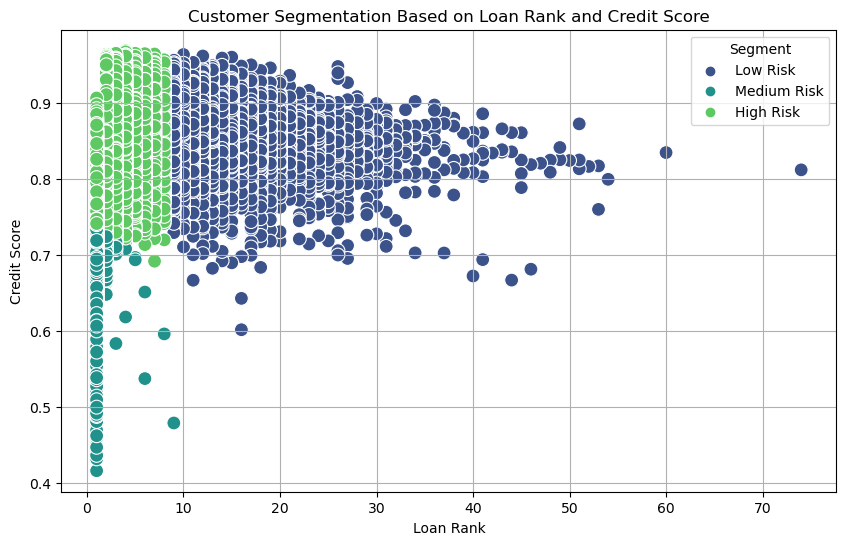

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df_sorted = df.sort_values(by='USER_LOAN_RANK', ascending=False)
df_sorted = df_sorted.iloc[3:] 
# Handle missing values
# Fix 1: Fill missing values with the median (alternative: use mean)
df_sorted['USER_LOAN_RANK'].fillna(df_sorted['USER_LOAN_RANK'].median(), inplace=True)
df_sorted['CREDIT_SCORE'].fillna(df_sorted['CREDIT_SCORE'].median(), inplace=True)
# Feature Selection
features = ['USER_LOAN_RANK', 'CREDIT_SCORE']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_sorted[features])
# Applying KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_sorted['Segment'] = kmeans.fit_predict(scaled_features)

segment_map = {0: 'High Risk', 1: 'Medium Risk', 2: 'Low Risk'}
df_sorted['Segment'] = df_sorted['Segment'].map(segment_map)

# Analyzing segment characteristics
segment_summary = df_sorted.groupby('Segment').agg({
    'USER_LOAN_RANK': ['mean', 'min', 'max'],
    'CREDIT_SCORE': ['mean', 'min', 'max'],
    'LOAN_STATUS': lambda x: (x == 'defaulted').mean()
}).reset_index()
segment_summary.columns = ['Segment', 'Avg Loan Rank', 'Min Loan Rank', 'Max Loan Rank',
                           'Avg Credit Score', 'Min Credit Score', 'Max Credit Score',
                           'Default Rate']
print(segment_summary)

# Visualizing customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sorted, x='USER_LOAN_RANK', y='CREDIT_SCORE', hue='Segment', palette='viridis', s=100)
plt.title('Customer Segmentation Based on Loan Rank and Credit Score')
plt.xlabel('Loan Rank')
plt.ylabel('Credit Score')
plt.legend(title='Segment')
plt.grid(True)
plt.show()


# Analysis of Loan Default and Repayment by Loan Rank


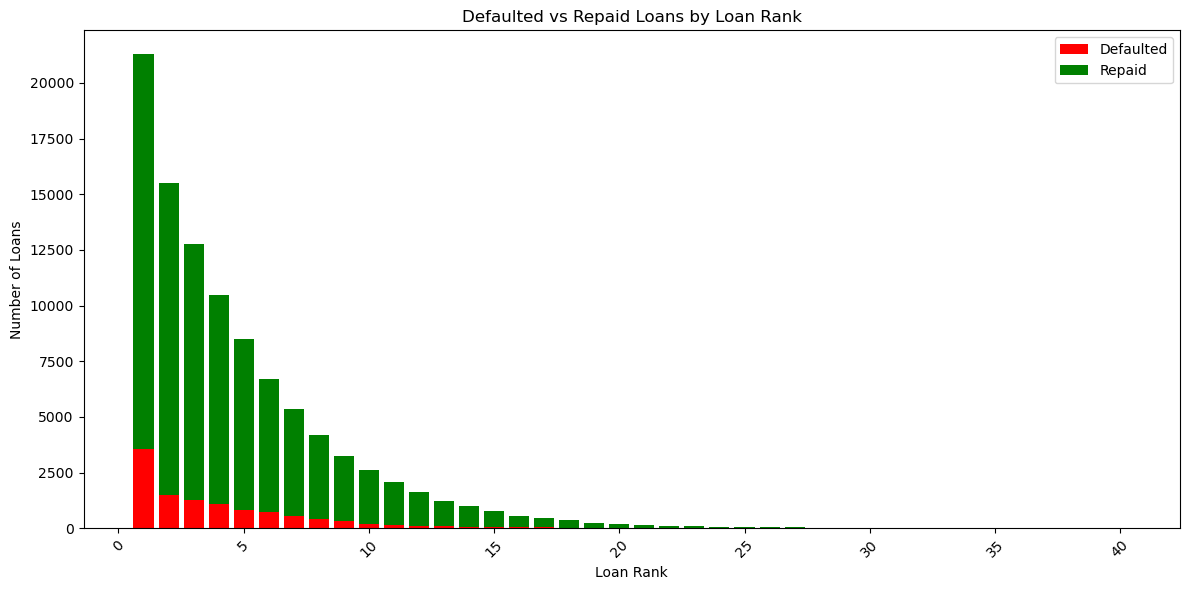

In [20]:
df['Defaulted'] = df['LOAN_STATUS'].apply(lambda x: 1 if x == 'defaulted' else 0)
default_repaid_analysis = df.groupby('USER_LOAN_RANK').agg({
    'Defaulted': 'sum',
    'LOAN_ID': 'count'
}).reset_index()
# Calculate the Repaid Loans (Total loans - Defaulted loans)
default_repaid_analysis['Repaid'] = default_repaid_analysis['LOAN_ID'] - default_repaid_analysis['Defaulted']

# Remove Loan Ranks greater than 40
default_repaid_analysis = default_repaid_analysis[default_repaid_analysis['USER_LOAN_RANK'] <= 40]


# Visualization: Stacked Bar Chart - Defaulted vs Repaid by Loan Rank
plt.figure(figsize=(12, 6))
plt.bar(
    default_repaid_analysis['USER_LOAN_RANK'], 
    default_repaid_analysis['Defaulted'], 
    label='Defaulted', 
    color='red'
)
plt.bar(
    default_repaid_analysis['USER_LOAN_RANK'], 
    default_repaid_analysis['Repaid'], 
    bottom=default_repaid_analysis['Defaulted'], 
    label='Repaid', 
    color='green'
)
plt.title('Defaulted vs Repaid Loans by Loan Rank')
plt.xlabel('Loan Rank')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


# Key Factors Influencing Loan Default Prediction

Accuracy: 0.8488

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     22301
           1       0.15      0.09      0.11      2699

    accuracy                           0.85     25000
   macro avg       0.52      0.51      0.51     25000
weighted avg       0.81      0.85      0.83     25000



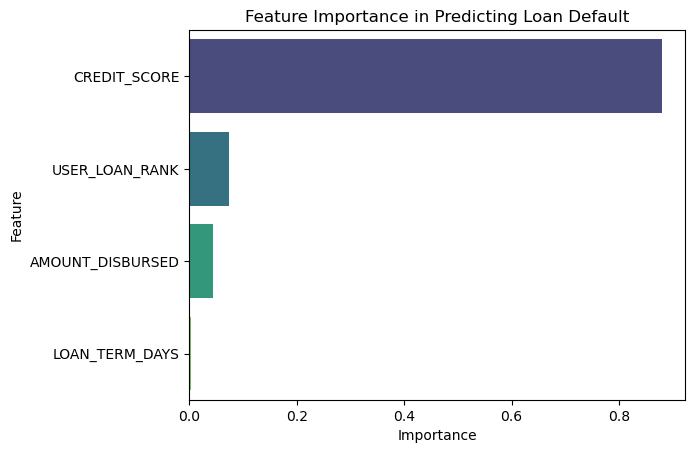

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# The target variable
df['is_default'] = df['LOAN_STATUS'].apply(lambda x: 1 if x == 'defaulted' else 0)

# Feature Selection
features = ['USER_LOAN_RANK', 'CREDIT_SCORE', 'AMOUNT_DISBURSED', 'LOAN_TERM_DAYS']
X = df[features]
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Building a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plotting Feature Importance
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance in Predicting Loan Default')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()